In [47]:
# Loading the data from the files
filename = "000000000139"
image_path = f'/training_data_2/yuetian/OWOD/JPEGImages/{filename}.jpg'  # Replace with your image path


filepaths = {
    "ground_truth": f"output/from_dataset/filtered_unknown/SOWODB/2021{filename}_gt.txt",
    "model_1": f"output/from_dataset/filtered_unknown/SOWODB/2021{filename}_t1.pth.txt",
    # "model_2": f"output/from_dataset/filtered_unknown/SOWODB/2021{filename}_t2.pth.txt",
    # "model_3": f"output/from_dataset/filtered_unknown/SOWODB/2021{filename}_t3.pth.txt",
    # "model_4": f"output/from_dataset/filtered_unknown/SOWODB/2021{filename}_t4.pth.txt"
}

# Storing the data from each file in a dictionary
data = {}
for key, filepath in filepaths.items():
    with open(filepath, "r") as file:
        data[key] = file.readlines()

h, w = map(int, data["ground_truth"][-1].strip().split(": ")[1].split(", "))

# Displaying the first few lines of each file to understand the data format
sample_data = {key: value[:5] for key, value in data.items()}
sample_data


{'ground_truth': ['BBOX: tensor([442.8687, 266.6666, 491.6594, 400.0000]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([ 13.1359, 313.6150, 294.6203, 493.8967]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([1045.2452,  392.4882, 1199.1234,  540.8450]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([671.8094, 409.3896, 778.7734, 602.8169]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([544.2031, 409.3896, 662.4266, 595.3052]), LABEL: unknown (ID: 80), PROB: 1.0\n'],
 'model_1': ['BBOX: tensor([-64.3846, 764.8824, 154.9559, 798.7250]), LABEL: unknown (ID: 80), PROB: 0.9972355961799622\n',
  'BBOX: tensor([ 32.4187, 783.1221, 986.3754, 805.7896]), LABEL: unknown (ID: 80), PROB: 0.9971975088119507\n',
  'BBOX: tensor([ -0.8038, 143.3353,   6.1013, 616.5537]), LABEL: unknown (ID: 80), PROB: 0.9825354814529419\n',
  'BBOX: tensor([1125.8502,  699.6915, 1197.9224,  796.3470]), LABEL: unknown (ID: 80), PROB: 0.9766013622283936\n',
  'BBOX: tensor([-4.61

In [48]:
import re
import torch

def parse_bbox(tensor_string):
    """Parse tensor string to extract bounding box coordinates."""
    coords = list(map(float, re.findall(r'([-+]?\d*\.\d+e[+-]?\d+|[-+]?\d*\.\d+|[-+]?\d+)', tensor_string)))
    return torch.tensor(coords)

def parse_data_line(line):
    """Parse a line from the data files to extract bounding box, label, ID, and probability."""
    bbox = parse_bbox(re.search(r'tensor\((.*?)\)', line).group(0))
    label = re.search(r'LABEL: (.*?)(?: \(|$)', line).group(1)
    label_id = int(re.search(r'ID: (\d+)', line).group(1))
    prob = float(re.search(r'PROB: (.+)', line).group(1))
    return {'bbox': bbox, 'label': label, 'label_id': label_id, 'prob': prob}


# Parsing the data again
parsed_data = {key: [parse_data_line(line) for line in value[:-1]] for key, value in data.items()}
parsed_data['model_1']


[{'bbox': tensor([-64.3846, 764.8824, 154.9559, 798.7250]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9972355961799622},
 {'bbox': tensor([ 32.4187, 783.1221, 986.3754, 805.7896]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9971975088119507},
 {'bbox': tensor([ -0.8038, 143.3353,   6.1013, 616.5537]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9825354814529419},
 {'bbox': tensor([1125.8502,  699.6915, 1197.9224,  796.3470]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9766013622283936},
 {'bbox': tensor([-4.6138e-01,  7.0459e+02,  1.1576e+01,  7.9469e+02]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9754346013069153},
 {'bbox': tensor([  93.1464,  146.5184, 1108.2571,  650.4271]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9716216325759888},
 {'bbox': tensor([165.5333, 610.2881, 226.2969, 632.3638]),
  'label': 'unknown',
  'label_id': 80,
  'prob': 0.9580672383308411},
 {'bbox': tensor([624.1953, 367.7325, 656.0339, 403.7578]),
  '

# Ensemble using lable info

In [49]:
# Combine all bounding boxes for the unknown class from all models
unknown_predictions = [
    pred for model in ['model_1', 'model_2', 'model_3', 'model_4'] 
    for pred in parsed_data[model] 
    if pred['label_id'] == 80
]

known_predictions = [
    pred for model in ['model_1', 'model_2', 'model_3', 'model_4'] 
    for pred in parsed_data[model] 
    if pred['label_id'] != 80
]

# Extract boxes and scores for NMS
unknown_boxes = torch.stack([pred['bbox'] for pred in unknown_predictions])
unknown_scores = torch.tensor([pred['prob'] for pred in unknown_predictions])

# Extract boxes and scores for NMS
known_boxes = torch.stack([pred['bbox'] for pred in known_predictions])
known_scores = torch.tensor([pred['prob'] for pred in known_predictions])

# Apply NMS
nms_unknown_indices = nms(unknown_boxes, unknown_scores, iou_threshold=0.5)
nms_filtered_unknown_predictions = [unknown_predictions[i] for i in nms_unknown_indices.tolist()]

# Apply NMS
nms_known_indices = nms(known_boxes, known_scores, iou_threshold=0.5)
nms_filtered_known_predictions = [known_predictions[i] for i in nms_known_indices.tolist()]

# Combine NMS-filtered bounding boxes for the unknown class with all bounding boxes for known classes
ensemble_predictions = nms_filtered_unknown_predictions + nms_filtered_known_predictions

len(nms_filtered_unknown_predictions), len(ensemble_predictions)  # Number of NMS-filtered unknown predictions and final predictions


KeyError: 'model_2'

In [275]:
def ensemble_unknown(predictions, threshold=0.75):
    """Ensemble method for unknown class where we require a threshold of models to agree."""
    agreed_boxes = []
    checked_indices = set()  # Set to keep track of indices we've already checked

    for i, box in enumerate(predictions):
        if i in checked_indices:
            continue

        agreeing_boxes = [box]
        checked_indices.add(i)

        for j, other_box in enumerate(predictions):
            if j in checked_indices:
                continue
            if iou(box['bbox'].unsqueeze(0), other_box['bbox'].unsqueeze(0)).item() > 0.5:
                agreeing_boxes.append(other_box)
                checked_indices.add(j)

        # If the number of models that agree is above the threshold
        if len(agreeing_boxes) / 4 >= threshold:
            avg_coords = torch.mean(torch.stack([ob['bbox'] for ob in agreeing_boxes]), dim=0)
            max_prob = max([ob['prob'] for ob in agreeing_boxes])

            agreed_boxes.append({'bbox': avg_coords, 'label_id': 80, 'prob': max_prob})

    return agreed_boxes

def ensemble_known(predictions):
    """Ensemble method for known classes."""
    combined_boxes = []

    # Organize boxes by label
    label_boxes = defaultdict(list)
    for pred in predictions:
        label_boxes[pred['label_id']].append(pred)

    for label_id, boxes in label_boxes.items():
        checked_indices = set()  # Set to keep track of indices we've already checked

        for i, box in enumerate(boxes):
            if i in checked_indices:
                continue

            overlapping_boxes = [box]
            checked_indices.add(i)

            # Find boxes that overlap with the current box
            for j, other_box in enumerate(boxes):
                if j in checked_indices:
                    continue
                if iou(box['bbox'].unsqueeze(0), other_box['bbox'].unsqueeze(0)).item() > 0.5:
                    overlapping_boxes.append(other_box)
                    checked_indices.add(j)

            # Average coordinates of overlapping boxes
            avg_coords = torch.mean(torch.stack([ob['bbox'] for ob in overlapping_boxes]), dim=0)
            max_prob = max([ob['prob'] for ob in overlapping_boxes])

            combined_boxes.append({'bbox': avg_coords, 'label_id': label_id, 'prob': max_prob})

    return combined_boxes


# Combine all bounding boxes for the known and unknown classes from all models
all_known_predictions = [
    pred for model in ['model_1', 'model_2', 'model_3', 'model_4'] 
    for pred in parsed_data[model] 
    if pred['label_id'] < 80
]

all_unknown_predictions = [
    pred for model in ['model_1', 'model_2', 'model_3', 'model_4'] 
    for pred in parsed_data[model] 
    if pred['label_id'] == 80
]


# Apply ensemble methods
ensemble_known_predictions = ensemble_known(all_known_predictions)
ensemble_unknown_predictions = ensemble_unknown(all_unknown_predictions)

ensemble_predictions = ensemble_known_predictions + ensemble_unknown_predictions


len(ensemble_unknown_predictions), len(ensemble_predictions)  # Number of ensemble predictions for known and unknown classes


(2, 3)

# Ensemble w/o lable information

In [15]:
import torch

def iou(bbox1, bbox2):
    '''Compute the Intersection-Over-Union of two bounding boxes.'''
    
    inter_x1 = max(bbox1[0], bbox2[0])
    inter_y1 = max(bbox1[1], bbox2[1])
    inter_x2 = min(bbox1[2], bbox2[2])
    inter_y2 = min(bbox1[3], bbox2[3])
    
    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)
    
    area1 = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
    area2 = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)
    
    union_area = area1 + area2 - inter_area
    
    return inter_area / union_area

def nms(predictions, iou_threshold):
    '''Non-Maximum Suppression to prune overlapping bounding boxes.'''
    
    if not predictions:
        return []
    
    predictions = sorted(predictions, key=lambda x: x['prob'], reverse=True)
    
    kept_predictions = []
    while predictions:
        # Take the prediction with the highest probability
        top_pred = predictions.pop(0)
        kept_predictions.append(top_pred)
        
        # Compare this top prediction with all other predictions
        filtered_predictions = []
        for pred in predictions:
            if iou(top_pred['bbox'], pred['bbox']) <= iou_threshold:
                filtered_predictions.append(pred)
        
        predictions = filtered_predictions
    
    return kept_predictions

def ensemble(data, method, nms_threshold=0.5):
    '''Implement the ensemble methods and apply NMS.'''
    
    model_keys = [key for key in data.keys() if "model" in key]
    final_predictions = []
    
    for key in model_keys:
        for prediction in data[key]:
            overlapping_boxes = []
            for other_key in model_keys:
                for other_prediction in data[other_key]:
                    if iou(prediction['bbox'], other_prediction['bbox']) > 0.5:
                        overlapping_boxes.append(other_prediction)
            
            if method == 'affirmative' or \
                (method == 'consensus' and len(overlapping_boxes) > len(model_keys) / 2) or \
                (method == 'unanimous' and len(overlapping_boxes) == len(model_keys)):
                final_predictions.append(prediction)
    
    # Apply NMS on final predictions
    final_predictions = nms(final_predictions, nms_threshold)
    
    return final_predictions

# Sample data is stored in the variable 'data'
affirmative_predictions = ensemble(parsed_data, 'affirmative')
consensus_predictions = ensemble(parsed_data, 'consensus')
unanimous_predictions = ensemble(parsed_data, 'unanimous')

print("Affirmative Predictions:", affirmative_predictions)
print("\nConsensus Predictions:", consensus_predictions)
print("\nUnanimous Predictions:", unanimous_predictions)


Affirmative Predictions: [{'bbox': tensor([ 996.5573,  334.8916, 1212.4908, 1303.3875]), 'label': 'unknown', 'label_id': 80, 'prob': 0.9198916554450989}, {'bbox': tensor([  -4.3606,  909.6324,   59.1420, 1234.2269]), 'label': 'unknown', 'label_id': 80, 'prob': 0.9185238480567932}, {'bbox': tensor([1063.1183,  738.1261, 1217.8909, 1294.6772]), 'label': 'unknown', 'label_id': 80, 'prob': 0.9098325371742249}, {'bbox': tensor([1098.1466,  253.0678, 1215.2051, 1253.7754]), 'label': 'unknown', 'label_id': 80, 'prob': 0.8932499885559082}, {'bbox': tensor([1160.3689,  879.9996, 1217.1432, 1305.0105]), 'label': 'unknown', 'label_id': 80, 'prob': 0.8646960258483887}, {'bbox': tensor([1150.1433,  131.8547, 1218.9944, 1380.4473]), 'label': 'unknown', 'label_id': 80, 'prob': 0.8563976883888245}, {'bbox': tensor([1135.6359,  427.7523, 1214.4473,  968.3239]), 'label': 'unknown', 'label_id': 80, 'prob': 0.7767500877380371}]

Consensus Predictions: [{'bbox': tensor([ 996.5573,  334.8916, 1212.4908, 130

# Vis and eval

In [63]:
# Adjusting the box unpacking
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def plot_image(ensemble_predictions, rescale):
    # Open an image file
    if rescale:
        image = np.array(Image.open(image_path).resize((w, h)))
    else:
        image = np.array(Image.open(image_path))# .resize((w, h)))
    print(image.shape)
    
    class_name = {'OWDETR': (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train',
    'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 
        'TOWOD': (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown')}
    
    CLASSES = class_name['OWDETR']
    
    
    def plot_results(pil_img, scores, boxes, labels, ax, plot_prob=True, norm=False, dataset='OWOD'):
        h, w = pil_img.shape[:-1]
        
        ax.imshow(pil_img)
        colors = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]] * 100
        if boxes is not None:
            for sc, cl, box, c in zip(scores, labels, boxes, colors):
                xmin, ymin, xmax, ymax = box
                ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                           fill=False, color=c, linewidth=2))
                text = f'{CLASSES[cl]}: {sc:0.2f}'
                ax.text(xmin, ymin, text, fontsize=5, bbox=dict(facecolor='yellow', alpha=0.5))
        ax.grid('off')
    
    # Plotting the results on the mock image again
    fig, ax = plt.subplots(figsize=(5, 5))
    scores = [pred['prob'] for pred in ensemble_predictions]
    boxes = [pred['bbox'] for pred in ensemble_predictions]
    labels = [pred['label_id'] for pred in ensemble_predictions]
    plot_results(image, scores, boxes, labels, ax)
    plt.grid(False)
    plt.show()

In [76]:
import torch
# 	x_min	y_min	x_max	y_max
# 	x_min	y_min	x_max	y_max
# parsed_data['ground_truth']
custom_data = [{
    'bbox': torch.tensor([419.1137785179017, 155.11464074999998, 468.3870641132389, 299.511707253]),
    'label': 'unknown',
    'label_id': 80,
    'prob': 1.0
}
]

(426, 640, 3)


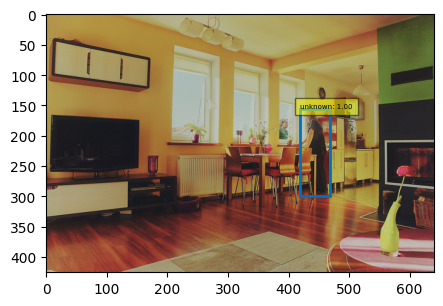

In [77]:
plot_image(custom_data, rescale=False)

In [70]:
# 	x_min	y_min	x_max	y_max
# 23	786.4932	291.2951	878.9576	562.4633
custom_data = [{
    'bbox': torch.tensor([786.4932, 291.2951, 878.9576, 562.4633]),
    'label': 'unknown',
    'label_id': 80,
    'prob': 1.0
}
]

(800, 1201, 3)


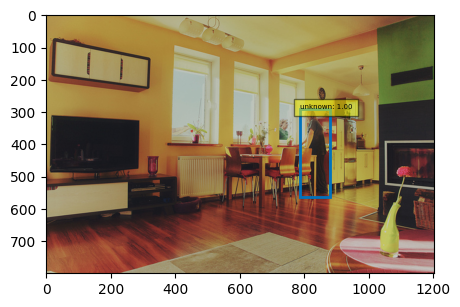

In [73]:
plot_image(custom_data, rescale=True)


(800, 1201, 3)


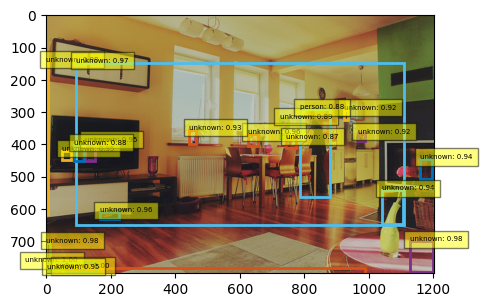

In [72]:
plot_image(parsed_data['model_1'], rescale=True)

In [298]:
def iou(a, b):
    """Compute the Intersection-Over-Union of two sets of boxes."""
    area_a = (a[:, 3] - a[:, 1]) * (a[:, 2] - a[:, 0])
    area_b = (b[:, 3] - b[:, 1]) * (b[:, 2] - b[:, 0])

    intersection_top_left = torch.max(a[:, None, :2], b[:, :2])
    intersection_bottom_right = torch.min(a[:, None, 2:], b[:, 2:])
    intersection_area = (intersection_bottom_right - intersection_top_left).clamp(min=0).prod(2)

    return intersection_area / (area_a[:, None] + area_b - intersection_area)

def compute_tp_fp(predictions, ground_truth, iou_threshold=0.5):
    """Compute the number of true positives and false positives."""
    tp = 0
    fp = 0
    gt_flags = [0] * len(ground_truth)  # Flags to mark if a ground truth box is matched

    for pred in predictions:
        max_iou = 0
        max_idx = -1
        for idx, gt in enumerate(ground_truth):
            curr_iou = iou(pred['bbox'].unsqueeze(0), gt['bbox'].unsqueeze(0)).item()
            if curr_iou > max_iou:
                max_iou = curr_iou
                max_idx = idx

        if max_iou >= iou_threshold:
            if gt_flags[max_idx] == 0:  # If this ground truth hasn't been matched before
                tp += 1
                gt_flags[max_idx] = 1
            else:
                fp += 1  # This ground truth has been matched before, so it's a false positive
        else:
            fp += 1

    return tp, fp

def get_precision(pred, gt, unknown=True):
    # Compute TP and FP for ensemble predictions of the unknown class
    if unknown: 
        gt = [gt for gt in parsed_data['ground_truth'] if gt['label_id'] == 80]
        pred = [pred_entry for pred_entry in pred if pred_entry['label_id'] == 80]
    tp, fp = compute_tp_fp(pred, gt)
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision
    

def get_recall(predictions, ground_truth, iou_threshold=0.5, unknown=True):
    """Compute recall for the ensemble predictions."""
    if unknown:
        ground_truth = [gt for gt in ground_truth if gt['label_id'] == 80]
        predictions = [pred for pred in predictions if pred['label_id'] == 80]
    
    tp, fp = compute_tp_fp(predictions, ground_truth, iou_threshold)
    fn = len(ground_truth) - tp
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return recall


In [299]:
for ket, value in parsed_data.items():
    print(get_precision(value, parsed_data['ground_truth'], unknown=False))
print(get_precision(affirmative_predictions, parsed_data['ground_truth'], unknown=False))

1.0
0.0
0.4
0.4
0.6
0.25


In [300]:
for ket, value in parsed_data.items():
    print(get_recall(value, parsed_data['ground_truth'], unknown=False))
print(get_recall(affirmative_predictions, parsed_data['ground_truth'], unknown=False))

1.0
0.0
0.4
0.4
0.6
0.6
